# 长短期记忆网络LSTM和传统的循环神经网络模型RNN

## 1 读取辐照度数据和光伏有功功率数据

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
import torch
import warnings
import time
import random
import os
warnings.filterwarnings("ignore")
def set_random_seed(seed_value):
    """设置随机种子"""
    np.random.seed(seed_value)  # NumPy
    random.seed(seed_value)  # Python
    torch.manual_seed(seed_value)  # PyTorch CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)  # PyTorch GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
#设置随机种子
set_random_seed(42)
#设置设备
device='cuda' if torch.cuda.is_available() else 'cpu'
#读取辐照度数据
df_weather=pd.read_csv('weatherdata.csv')
#读取光伏有功功率数据
df_power=pd.read_csv('pvdata.csv')

#打印数据查看数据字段是否符合预期
print(df_weather.head(5))
print(df_power.head(5))

#检查是否含有缺失值，如果有缺失值，采用线性插值的方式填充
df_weather.interpolate(method='linear',inplace=True)
df_power.interpolate(method='linear',inplace=True)

#去除时间戳列
df_weather.drop(columns=['timestamp'],inplace=True)
df_power.drop(columns=['timestamp'],inplace=True)


             timestamp  Global_Horizontal_Radiation
0  2015-01-01 00:00:00                          0.0
1  2015-01-01 00:05:00                          0.0
2  2015-01-01 00:10:00                          0.0
3  2015-01-01 00:15:00                          0.0
4  2015-01-01 00:20:00                          0.0
             timestamp  activePower
0  2015-01-01 00:00:00          0.0
1  2015-01-01 00:05:00          0.0
2  2015-01-01 00:10:00          0.0
3  2015-01-01 00:15:00          0.0
4  2015-01-01 00:20:00          0.0


## 2 划分训练集、验证集、测试集，并使用训练集的参数进行归一化，避免信息泄露

torch.Size([32, 48, 1]) torch.Size([32, 48, 1]) torch.Size([32, 48, 1])


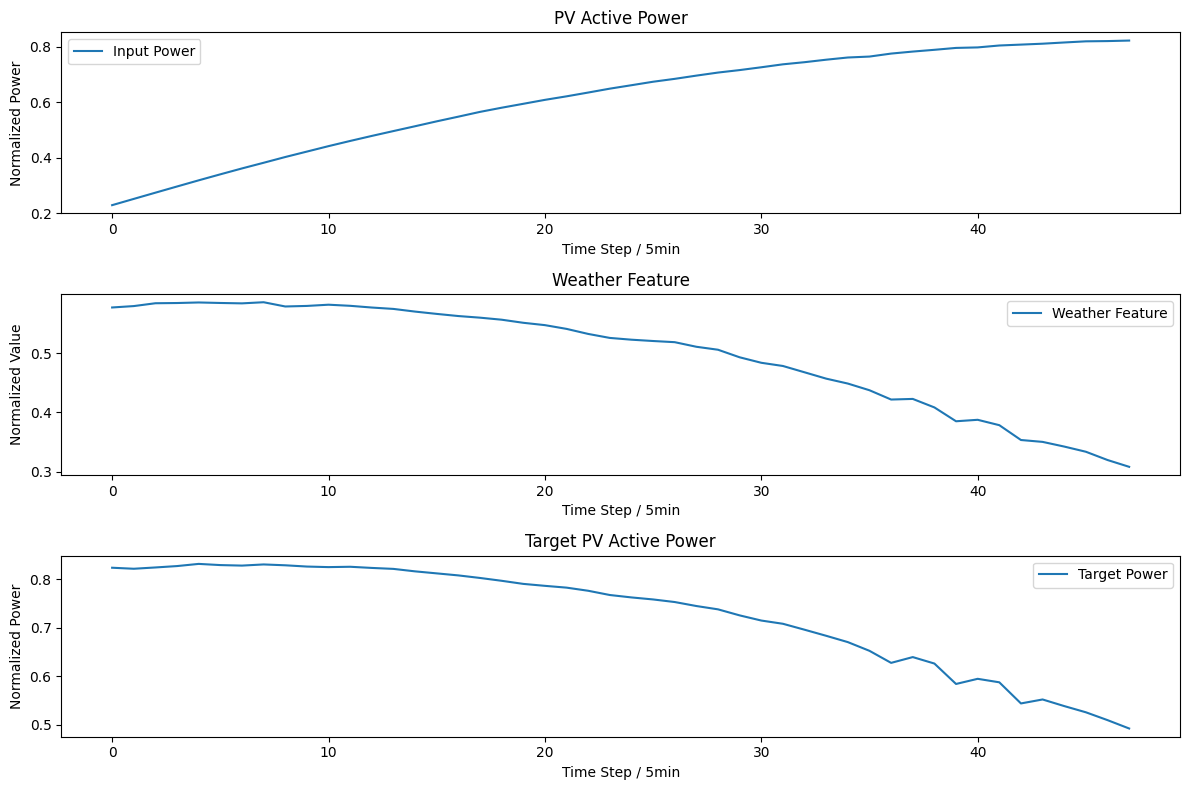

In [18]:
#定义数据集
class PVData(Dataset):
    def __init__(self, power,weather,input_len,output_len,step):
        self.power = power
        self.weather = weather
        self.input_len=input_len
        self.output_len=output_len
        self.step=step 
    
    def __len__(self):
        return (len(self.power)-self.input_len-self.output_len)//self.step+1
    def __getitem__(self, index):
        power_start=index*self.step
        power_end=power_start+self.input_len

        weather_start=power_end
        weather_end=weather_start+self.output_len

        target_start=power_end
        target_end=target_start+self.output_len

        power_seq=self.power[power_start:power_end]
        weather_seq=self.weather[weather_start:weather_end]
        target_seq=self.power[target_start:target_end]

        return torch.Tensor(power_seq),torch.Tensor(weather_seq),torch.Tensor(target_seq)
    
#划分数据集
train_ratio,val_ratio,test_ratio=0.7,0.1,0.2
data_len=len(df_power)
train_len=int(data_len*train_ratio)
val_len=int(data_len*val_ratio)
test_len=data_len-train_len-val_len

#训练集
power_train=df_power[:train_len]
weather_train=df_weather[:train_len]
#验证集
power_val=df_power[train_len:train_len+val_len]
weather_val=df_weather[train_len:train_len+val_len]
#测试集
power_test=df_power[train_len+val_len:]
weather_test=df_weather[train_len+val_len:]

#归一化
weather_scaler=MinMaxScaler()
power_scaler=MinMaxScaler()
#对训练集进行归一化
weather_train=weather_scaler.fit_transform(weather_train)
power_train=power_scaler.fit_transform(power_train)
#使用训练集参数对验证集和测试集归一化
weather_val=weather_scaler.transform(weather_val)
weather_test=weather_scaler.transform(weather_test)
power_val=power_scaler.transform(power_val)
power_test=power_scaler.transform(power_test)

#设置批次大小，并创建数据加载器
batch_size=32
input_len=48 #输入数据长度
output_len=48 #输出数据长度
step=48 #样本间的不重复时间步长
input_channel=2 #输入数据通道数
output_channel=1 #输出数据通道数
train_dataset=PVData(power_train,weather_train,input_len,output_len,step)
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataset=PVData(power_val,weather_val,input_len,output_len,step)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_dataset=PVData(power_test,weather_test,input_len,output_len,step)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

#测试数据加载器是否正常
#获取一个批次的数据
for power_seq,weather_seq,target_seq in train_loader:
    print(power_seq.shape,weather_seq.shape,target_seq.shape)
    #绘制三个子图
    fig, axs = plt.subplots(3, 1, figsize=(12, 8))
    # 绘制输入有功功率子图
    axs[0].plot(power_seq[0, :, 0], label='Input Power')
    axs[0].set_title('PV Active Power')
    axs[0].set_xlabel('Time Step / 5min')
    axs[0].set_ylabel('Normalized Power')
    axs[0].legend()
    # 绘制天气子图
    axs[1].plot(weather_seq[0, :, 0], label='Weather Feature')
    axs[1].set_title('Weather Feature')
    axs[1].set_xlabel('Time Step / 5min')
    axs[1].set_ylabel('Normalized Value')
    axs[1].legend()
    # 绘制目标光伏有功功率子图
    axs[2].plot(target_seq[0, :, 0], label='Target Power')
    axs[2].set_title('Target PV Active Power')
    axs[2].set_xlabel('Time Step / 5min')
    axs[2].set_ylabel('Normalized Power')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

    break

## 3 构建长短期记忆网络LSTM和原始循环神经网络RNN

In [19]:
#构建LSTM
class LSTM(nn.Module):
    """
    LSTM模型
    输入数据形状为(batch_size, input_len, input_channel)
    输出数据形状为(batch_size, output_len, output_channel)
    """
    def __init__(self, input_len,input_channel, hidden_size, num_layers, output_len,output_channel):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_len=input_len
        self.output_len=output_len
        self.lstm = nn.LSTM(input_channel, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_channel)
        self.len_adjust=nn.Linear(input_len,output_len)

    def forward(self, x):
        # 输入LSTM
        x, _ = self.lstm(x) #x的形状为(batch_size, input_len, hidden_size)
        # 输出LSTM
        x = self.fc(x) #x的形状为(batch_size, input_len, output_channel)
        # 调整输出长度
        if self.input_len!=self.output_len:
            x=self.len_adjust(x.permute(0,2,1)).permute(0,2,1) #x的形状为(batch_size, output_len, output_channel)
        return x
    
#构建RNN模型
class RNN(nn.Module):
    """
    RNN模型
    输入数据形状为(batch_size, input_len, input_channel)
    输出数据形状为(batch_size, output_len, output_channel)
    """
    def __init__(self, input_len,input_channel, hidden_size, num_layers, output_len,output_channel):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_len=input_len
        self.output_len=output_len
        self.rnn = nn.RNN(input_channel, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_channel)
        self.len_adjust=nn.Linear(input_len,output_len)

    def forward(self, x):
        # 输入RNN
        x, _ = self.rnn(x) #x的形状为(batch_size, input_len, hidden_size)
        # 输出RNN
        x = self.fc(x) #x的形状为(batch_size, input_len, output_channel)
        # 调整输出长度
        if self.input_len!=self.output_len:
            x=self.len_adjust(x.permute(0,2,1)).permute(0,2,1) #x的形状为(batch_size, output_len, output_channel)
        return x
    
#初始化模型和优化器
hidden_dim=128
lr=0.0001
criterion=nn.MSELoss()

lstm=LSTM(
    input_len=input_len,input_channel=input_channel,hidden_size=hidden_dim,
    num_layers=2,output_len=output_len,output_channel=output_channel)
optimizer_lstm=torch.optim.Adam(lstm.parameters(),lr=lr)

rnn=RNN(
    input_len=input_len,input_channel=input_channel,hidden_size=hidden_dim,
    num_layers=2,output_len=output_len,output_channel=output_channel)
optimizer_rnn=torch.optim.Adam(rnn.parameters(),lr=lr)

model_list=[lstm,rnn]
model_name_list=['LSTM','RNN']
optimizer_list=[optimizer_lstm,optimizer_rnn]

for model in model_list:
    model.to(device)

#设置模型权重保存目录
save_path="model_weight"
os.makedirs(save_path,exist_ok=True) #创建模型保存目录(如果没有目录的话)


## 4 模型训练

LSTM早停法触发，第101轮
LSTM 训练时间: 12.9845秒


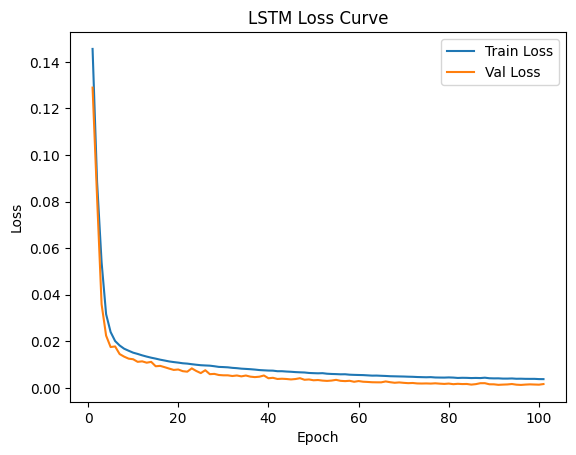

RNN早停法触发，第49轮
RNN 训练时间: 5.5731秒


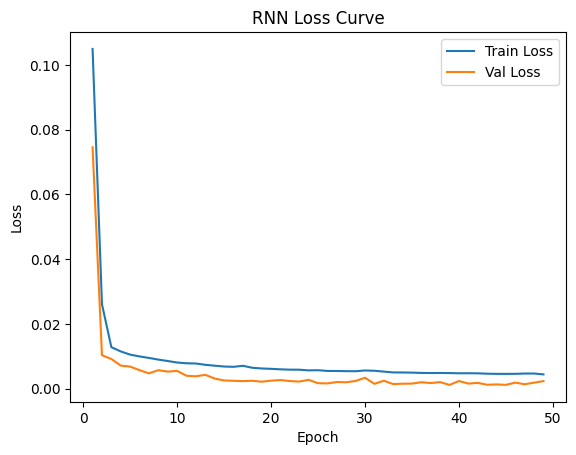

In [20]:
#设置模型训练超参数
epochs=300
patience=10
delta=0.0001

def train(model,optimizer,model_name,criterion):
    """
    model:神经网络模型
    optimizer:优化器
    model_name:模型名称
    criterion:损失函数
    """
    #记录开始训练时间
    start_time=time.time()
    model.to(device)

    best_loss=float('inf')
    early_stop_count=0
    train_losses=[]
    val_losses=[]
    for epoch in range(1,epochs+1):
        model.train()
        train_loss=0
        for power_seq,weather_seq,target_seq in train_loader:
            power_seq=power_seq.to(device)
            weather_seq=weather_seq.to(device)
            target_seq=target_seq.to(device)

            #在特征维度拼接光伏功率数据和气象数据
            input_seq=torch.cat((power_seq,weather_seq),dim=2)
            #前向传播
            output_seq=model(input_seq)
            #计算损失
            loss=criterion(output_seq,target_seq)
            #反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)#梯度剪枝
            optimizer.step()
            #保存损失
            train_loss+=loss.item()
        train_loss/=len(train_loader)
        train_losses.append(train_loss)
        
        #早停法
        model.eval()
        with torch.no_grad():
            val_loss=0
            for power_seq,weather_seq,target_seq in val_loader:
                power_seq=power_seq.to(device)
                weather_seq=weather_seq.to(device)
                target_seq=target_seq.to(device)
                #在特征维度拼接光伏功率数据和气象数据
                input_seq=torch.cat((power_seq,weather_seq),dim=2)
                #前向传播
                output_seq=model(input_seq)
                #计算损失
                loss=criterion(output_seq,target_seq)
                #保存损失
                val_loss+=loss.item()
            val_loss/=len(val_loader)
            val_losses.append(val_loss)

            #早停法判断
            if val_loss<best_loss-delta:
                best_loss=val_loss
                early_stop_count=0
                #保存最优模型
                model_path=os.path.join(save_path,f'{model_name}.pth')
                torch.save(model.state_dict(),model_path)
            else:
                early_stop_count+=1
                if early_stop_count>=patience:
                    print(f"{model_name}早停法触发，第{epoch}轮")
                    break
    #记录训练结束时间
    end_time=time.time()
    #计算训练时间
    training_time=end_time-start_time
    print(f"{model_name} 训练时间: {training_time:.4f}秒")
    
    #绘制训练损失曲线图
    plt.plot(range(1,epoch+1),train_losses,label='Train Loss')
    plt.plot(range(1,epoch+1),val_losses,label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss Curve')
    plt.legend()
    plt.show()

#训练模型
for model,optimizer,model_name in zip(model_list,optimizer_list,model_name_list):
    train(model,optimizer,model_name,criterion)


## 5 模型测试

In [21]:
def test(model,model_name):
    model.eval()
    model.to(device)
    all_pred_seq=[]
    all_target_seq=[]
    with torch.no_grad():
        for i,(power_seq,weather_seq,target_seq) in enumerate(test_loader):
            power_seq=power_seq.to(device)
            weather_seq=weather_seq.to(device)
            target_seq=target_seq.to(device)
            #拼接输入序列
            input_seq=torch.cat((power_seq,weather_seq),dim=2)
            #向前传播
            pred_seq=model(input_seq)
            #将预测序列和目标序列转移到CPU
            pred_seq=pred_seq.detach().cpu()
            target_seq=target_seq.detach().cpu()
            #将当前批次的预测序列和目标序列添加到列表中
            all_pred_seq.append(pred_seq)
            all_target_seq.append(target_seq)

        #拼接所有batch
        all_pred_seq=torch.cat(all_pred_seq,dim=0) # 形状为(B,L,C)
        all_target_seq=torch.cat(all_target_seq,dim=0) # 形状为(B,L,C)

        # 去掉特征维 (B, L, 1) -> (B, L)
        pred = all_pred_seq.squeeze(-1)
        target = all_target_seq.squeeze(-1)

        # 展平为一维 (B * L)
        pred_np = pred.numpy().reshape(-1)
        target_np = target.numpy().reshape(-1)

        # === 指标计算 ===
        mse = mean_squared_error(target_np, pred_np)
        mae = mean_absolute_error(target_np, pred_np)
        r2 = r2_score(target_np, pred_np)

        print("-"*50)
        print(f'{model_name}的预测精度如下：')
        print(f"MSE: {mse:.6f}")
        print(f"MAE: {mae:.6f}")
        print(f"R2 : {r2:.6f}")
        print("-"*50)

#测试模型
for model,model_name in zip(model_list,model_name_list):
    #载入模型参数文件
    model_path=os.path.join(save_path,f'{model_name}.pth')
    model.load_state_dict(torch.load(model_path,map_location=device,weights_only=True))
    #测试模型
    test(model,model_name)


--------------------------------------------------
LSTM的预测精度如下：
MSE: 0.003978
MAE: 0.039028
R2 : 0.960005
--------------------------------------------------
--------------------------------------------------
RNN的预测精度如下：
MSE: 0.003026
MAE: 0.034702
R2 : 0.969578
--------------------------------------------------


## 6 LSTM与RNN预测结果可视化

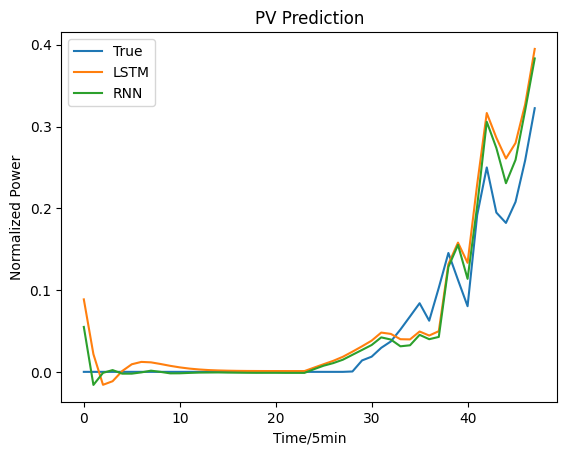

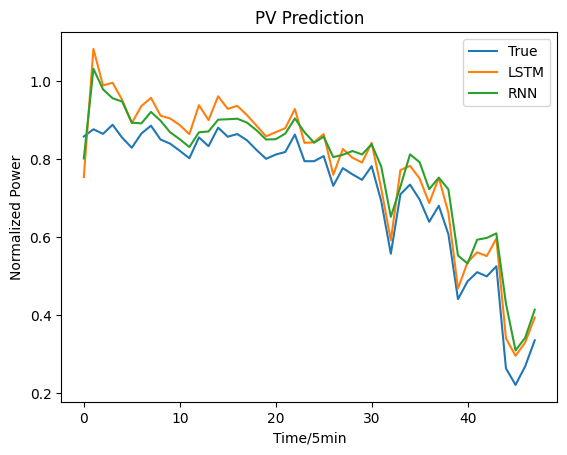

In [22]:
for i,(power_seq,weather_seq,target_seq) in enumerate(test_loader):
    #转移到设备
    power_seq=power_seq.to(device)
    weather_seq=weather_seq.to(device)
    target_seq=target_seq.to(device)
    
    if i % 10 ==0:
        plt.plot(target_seq[0,:,0].cpu().numpy(),label='True')
        for model,model_name in zip(model_list,model_name_list):
            model.eval()
            with torch.no_grad():
                #向前传播
                input_seq=torch.cat((power_seq,weather_seq),dim=2)
                pred_seq=model(input_seq)
                #将预测序列转移到CPU
                pred_seq=pred_seq.detach().cpu()
                plt.plot(pred_seq[0,:,0].numpy(),label=model_name)
        plt.xlabel('Time/5min')
        plt.ylabel('Normalized Power')
        plt.title('PV Prediction')
        plt.legend()
        plt.show()